In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from astropy.stats import jackknife_stats
import multiprocessing as mp
import time

In [2]:
# UNIFORM RANDOM DISTRIBUTION OF POINTS ON UNIT SPHERE.
def random_spin():
#     x = np.random.normal(0, 1, 3)
#     x = x/np.sqrt(x@x)
    p = np.random.random()
    if (p > 0.5):
        x = np.array([+1, 0, 0])
    else:
        x = np.array([-1, 0, 0])
    return x

# RETURN THE VALUE OF SPIN MAGNITUDE.
def spin(site):
    i_ = site[0]%n
    j_ = site[1]%n
    s = spin_config[i_][j_]
    if (len(s) == 3):
        spin_val = 1
    elif (len(s) == 2):
        spin_val = 0
        
    return spin_val

# RETURN ENERGY OF SINGLET
def energy_singlet(J):
    E_T = ((3*J)/4)*((np.exp(-beta*J) - 1)/(3*np.exp(-beta*J) + 1))
    return E_T

# INITIALIZE ENERGY OF THE SYSTEM.
def initialize_energy():
    Energy = 0
    for i in range(n):
        for j in range(n):
            Energy += (J1/4)*(dot(spin_config[i][j], spin_config[(i+1)%n][j]) + dot(spin_config[i][j],spin_config[i][(j+1)%n]))
            Energy += (J2/4)*(dot(spin_config[i][j], spin_config[(i+1)%n][(j+1)%n]) + dot(spin_config[i][j], spin_config[(i+1)%n][(j-1)%n]))
        
    return Energy

def calculate_energy():
    Energy = 0
    for i in range(n):
        for j in range(n):
            Energy += (J1/4)*(dot(spin_config[i][j], spin_config[(i+1)%n][j]) + dot(spin_config[i][j],spin_config[i][(j+1)%n]))
            Energy += (J2/4)*(dot(spin_config[i][j], spin_config[(i+1)%n][(j+1)%n]) + dot(spin_config[i][j], spin_config[(i+1)%n][(j-1)%n]))
    
    count_J1 = 0
    count_J2 = 0
    
    for i in range(n):
        for j in range(n):
            if (len(spin_config[i][j]) == 2):
                site1 = [i, j]
                site2 = spin_config[i][j]
                if (dist(site1, site2) == 1):
                    count_J1 +=1
                elif(dist(site1, site2) == 2):
                    count_J2 +=1
    
    Energy = Energy + (count_J1/2)*energy_singlet(J1) + (count_J2/2)*energy_singlet(J2)
    
    return Energy

In [3]:
# DOT PRODUCT DEFINITION

def dot(v1, v2):
    if (len(v1) == 3 and len(v2) == 3):
        dot_prod = v1@v2
    else:
        dot_prod = 0
        
    return dot_prod

# DISTANCES ON A TORUS

def dist(site1, site2):
    ix = site1[0]
    iy = site1[1]
    jx = site2[0]
    jy = site2[1]
    
    rx = abs(ix - jx)
    if (rx >= n/2):
        distancex = n - rx
    else:
        distancex = rx
        
    ry = abs(iy - jy)
    if (ry >= n/2):
        distancey = n - ry
    else:
        distancey = ry
    
    if (distancex == 0 or distancey == 0):
        distance = 1
        
    elif (distancex == 1 and distancey == 1):
        distance = 2
    
    else:
        print("Error?")
    
    return distance

In [4]:
def make_dimer(site):
    global E
    global spin_config

    ix = site[0]
    iy = site[1]
    
    unpaired_list = []
    for nbr in [[ix+1, iy], [ix-1, iy], [ix, iy+1], [ix, iy-1], [ix-1, iy-1], [ix-1, iy+1], [ix+1, iy-1], [ix+1, iy+1]]:
        if (spin(nbr) == 1):
            unpaired_list.append(nbr)
    
    if(len(unpaired_list)==0):
        return
    
    else:
        unpaired_indices = np.random.choice(len(unpaired_list))
        unpaired_data = unpaired_list[unpaired_indices]
        
        jx = unpaired_data[0]%n
        jy = unpaired_data[1]%n

        if (dist([ix, iy], [jx, jy]) == 1):
            J = J1
        elif(dist([ix, iy], [jx, jy]) == 2):
            J = J2

        # Calculate the change in energy if dimer is formed.
        E_1 = energy_singlet(J)
        E_2 = - (J1/4)*(dot(spin_config[ix][iy], spin_config[(ix-1)%n][iy]) + dot(spin_config[ix][iy], spin_config[(ix+1)%n][iy]) + dot(spin_config[ix][iy], spin_config[ix][(iy-1)%n]) + dot(spin_config[ix][iy], spin_config[ix][(iy+1)%n]) + dot(spin_config[jx][jy], spin_config[(jx-1)%n][jy]) + dot(spin_config[jx][jy], spin_config[(jx+1)%n][jy]) + dot(spin_config[jx][jy], spin_config[jx][(jy+1)%n]) + dot(spin_config[jx][jy], spin_config[jx][(jy-1)%n]))
        E_3 = - (J2/4)*(dot(spin_config[ix][iy], spin_config[(ix-1)%n][(iy-1)%n]) + dot(spin_config[ix][iy], spin_config[(ix+1)%n][(iy-1)%n]) + dot(spin_config[ix][iy], spin_config[(ix-1)%n][(iy+1)%n]) + dot(spin_config[ix][iy], spin_config[(ix+1)%n][(iy+1)%n]) + dot(spin_config[jx][jy], spin_config[(jx-1)%n][(jy-1)%n]) + dot(spin_config[jx][jy], spin_config[(jx+1)%n][(jy-1)%n]) + dot(spin_config[jx][jy], spin_config[(jx-1)%n][(jy+1)%n]) + dot(spin_config[jx][jy], spin_config[(jx+1)%n][(jy+1)%n]))
        #         E_3 = - (J2/4)*(dot(spin_config[ix], spin_config[(ix - 2)%n]) + dot(spin_config[ix], spin_config[(ix + 2)%n]) + dot(spin_config[jx], spin_config[(jx - 2)%n]) + dot(spin_config[jx], spin_config[(jx + 2)%n]))
        E_4 = (J/4)*(dot(spin_config[ix][iy], spin_config[jx][jy]))

        dE = E_1 + E_2 + E_3 + E_4

        # Metropolis implementation.

        p_accept = min(1, np.exp(-beta*dE))
        if (np.random.random() <= p_accept):
            spin_config[ix][iy] = [jx, jy]
            spin_config[jx][jy] = [ix, iy]
            E += dE

In [5]:
def spin_rotation(site):
    global E
    global spin_config

    ix = site[0]
    iy = site[1]
    
    spin_new = random_spin()
    dS = spin_new - spin_config[ix][iy]
    
    # Calculating change in E.
    dE1= (J1/4)*(dot(dS, spin_config[(ix - 1)%n][iy]) + dot(dS, spin_config[(ix + 1)%n][iy]) + dot(dS, spin_config[ix][(iy - 1)%n]) + dot(dS, spin_config[ix][(iy + 1)%n])) 
    dE2= (J2/4)*(dot(dS, spin_config[(ix - 1)%n][(iy - 1)%n]) + dot(dS, spin_config[(ix + 1)%n][(iy - 1)%n]) + dot(dS, spin_config[(ix - 1)%n][(iy + 1)%n]) + dot(dS, spin_config[(ix + 1)%n][(iy + 1)%n]))
    
    dE = dE1 + dE2
    # Metropolis implementation.
    
    p_accept = min(1, np.exp(-beta*dE))
    
#     print(dE, p_accept)
    if (np.random.random() <= p_accept):
        spin_config[ix][iy] = spin_new
        E += dE

In [6]:
def break_dimer(site):
    global E
    global spin_config

    ix = site[0]
    iy = site[1]
    
    jx = spin_config[ix][iy][0]
    jy = spin_config[ix][iy][1]
    
    if (dist([ix, iy], [jx, jy]) == 1):
        J = J1
    elif(dist([ix, iy], [jx, jy]) == 2):
        J = J2
     
    spin_config_new = np.copy(spin_config)

    # Modifying a copy of the spin configutation.
    
    spin_config_new[ix][iy] = random_spin()
    spin_config_new[jx][jy] = random_spin()
    
    # Calculate the change in energy if dimer is broken.
    E_1 = - energy_singlet(J) 
    E_2 = + (J1/4)*(dot(spin_config_new[ix][iy], spin_config_new[(ix-1)%n][iy]) + dot(spin_config_new[ix][iy], spin_config_new[(ix+1)%n][iy]) + dot(spin_config_new[ix][iy], spin_config_new[ix][(iy-1)%n]) + dot(spin_config_new[ix][iy], spin_config_new[ix][(iy+1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx-1)%n][jy]) + dot(spin_config_new[jx][jy], spin_config_new[(jx+1)%n][jy]) + dot(spin_config_new[jx][jy], spin_config_new[jx][(jy+1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[jx][(jy-1)%n]))
    E_3 = + (J2/4)*(dot(spin_config_new[ix][iy], spin_config_new[(ix-1)%n][(iy-1)%n]) + dot(spin_config_new[ix][iy], spin_config_new[(ix+1)%n][(iy-1)%n]) + dot(spin_config_new[ix][iy], spin_config_new[(ix-1)%n][(iy+1)%n]) + dot(spin_config_new[ix][iy], spin_config_new[(ix+1)%n][(iy+1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx-1)%n][(jy-1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx+1)%n][(jy-1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx-1)%n][(jy+1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx+1)%n][(jy+1)%n]))
    E_4 = - (J/4)*(dot(spin_config_new[ix][iy], spin_config_new[jx][jy]))

    dE = E_1 + E_2 + E_3 + E_4
    
    # Metropolis implementation.
    
    p_accept = min(1, np.exp(-beta*dE))
    if (np.random.random() <= p_accept):
        spin_config[ix][iy] = spin_config_new[ix][iy]
        spin_config[jx][jy] = spin_config_new[jx][jy]
        E += dE

In [7]:
# MONTE CARLO SWEEP (RANDOM)

def monte_carlo_sweep(sweep_no):
    
    for i in range(n*n):
        
        ix = int(np.random.random()*n)
        iy = int(np.random.random()*n)
        
        site = [ix, iy]
        
        # f tunes the ratio of random spin rotations to dimer formation. Increase f to increase dimer formation.
        f = 0.25

        # If the chosen site has a free spin.
        if (spin(site) == 1):
            if (f <= np.random.random()):
                spin_rotation(site)
            else:
                make_dimer(site)

        # If the chosen site is part of a dimer.        
        elif (spin(site) == 0):
            break_dimer(site)

    # One MC Sweep Over.
        
    free_spins = []
    
    count_dimer = 0
    for i in range(n):
        for j in range(n):
            if (spin([i, j]) == 1):
                free_spins.append([i, j])
            else:
                count_dimer +=1
    
    if(len(free_spins)==0):
        iene = E/(n*n)
        stot = np.zeros((3), dtype=np.float64)
        m_stagππ = np.zeros((3), dtype=np.float64)
        m_stag0π = np.zeros((3), dtype=np.float64)
        m_stagπ0 = np.zeros((3), dtype=np.float64)
        ndimer = count_dimer
    
        return iene, stot, m_stagππ, m_stag0π, m_stagπ0, ndimer
    
    else:
        S = np.zeros((3), dtype=np.float64)
        M_ππ = np.zeros((3), dtype=np.float64)
        M_π0 = np.zeros((3), dtype=np.float64)
        M_0π = np.zeros((3), dtype=np.float64)
        
        for sites in free_spins:
            S += np.array(spin_config[sites[0]][sites[1]])
            M_ππ += np.array(spin_config[sites[0]][sites[1]])*((-1)**(sites[0]+sites[1]))
            M_π0 += np.array(spin_config[sites[0]][sites[1]])*((-1)**(sites[0]))
            M_0π += np.array(spin_config[sites[0]][sites[1]])*((-1)**(sites[1]))
            
    iene = E/(n*n)
    stot = S/(n*n)
    m_stagππ = M_ππ/(n*n)
    m_stag0π = M_0π/(n*n)
    m_stagπ0 = M_π0/(n*n)
    ndimer = count_dimer

    return iene, stot, m_stagππ, m_stag0π, m_stagπ0, ndimer

In [8]:
# SIMULATION FUNCTION (INITIALIZE THE LATTICE BEFOREHAND)

def simulation(n, T, J2byJ1, nsweeps, anneal_str):
    
    global J2
    global beta
    
    J2 = J2byJ1*J1
    beta = 1/T
    
#     for i in range(n):
#         for j in range(n):
#             spin_config[i][j] = np.array([0.57735027, 0.57735027, 0.57735027])*((-1)**(i+j))
#             spin_config[i][j] = random_spin()

    global E 
    E = calculate_energy()

    E_list = []
    S_list = []
    Mππ_list = []
    M0π_list = []
    Mπ0_list = []
    D_list = []
    
    neqsweeps = int(0.1*nsweeps)

    for i in range(nsweeps):
            E_meas, S_meas, Mππ_meas, M0π_meas, Mπ0_meas, D_meas = monte_carlo_sweep(i)
            
            if (i > neqsweeps):
                E_list.append(E_meas)
                S_list.append(S_meas)
                Mππ_list.append(Mππ_meas)
                M0π_list.append(M0π_meas)
                Mπ0_list.append(Mπ0_meas)
                D_list.append(D_meas)
            
#             if(i%100 == 0):
#                 print(i)
                
    E_list = np.array(E_list)
    S_list = np.array(S_list)
    Mππ_list = np.array(Mππ_list)
    M0π_list = np.array(M0π_list)
    Mπ0_list = np.array(Mπ0_list)
    D_list = np.array(D_list)
    
    magS_list = np.sqrt(np.array(S_list).T[0]**2 + np.array(S_list).T[1]**2 + np.array(S_list).T[2]**2)
    magMππ_list = np.sqrt(np.array(Mππ_list).T[0]**2 + np.array(Mππ_list).T[1]**2 + np.array(Mππ_list).T[2]**2)
    magM0π_list = np.sqrt(np.array(M0π_list).T[0]**2 + np.array(M0π_list).T[1]**2 + np.array(M0π_list).T[2]**2)
    magMπ0_list = np.sqrt(np.array(Mπ0_list).T[0]**2 + np.array(Mπ0_list).T[1]**2 + np.array(Mπ0_list).T[2]**2)
                
    test_statistic = np.mean
    
    avg_E, bias_E, stderr_E, conf_interval_E = jackknife_stats(E_list, test_statistic, 0.95)
    avg_S, bias_S, stderr_S, conf_interval_S = jackknife_stats(magS_list, test_statistic, 0.95)
    avg_Mππ, bias_Mππ, stderr_Mππ, conf_interval_Mππ = jackknife_stats(magMππ_list, test_statistic, 0.95)
    avg_M0π, bias_M0π, stderr_M0π, conf_interval_M0π = jackknife_stats(magM0π_list, test_statistic, 0.95)
    avg_Mπ0, bias_Mπ0, stderr_Mπ0, conf_interval_Mπ0 = jackknife_stats(magMπ0_list, test_statistic, 0.95)
    avg_D, bias_D, stderr_D, conf_interval_D = jackknife_stats(D_list, test_statistic, 0.95)
    
    
    data = [T, J2byJ1, avg_E, stderr_E, avg_S, stderr_S, avg_Mππ, stderr_Mππ, avg_M0π, stderr_M0π, avg_Mπ0, stderr_Mπ0, avg_D, stderr_D]
    
    with open("anneal_data/Ising_" + str(J2byJ1) + "_L_" + str(n) + "_AFM_initial_" + str(anneal_str) + ".csv", 'a', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(data)

In [11]:
# DEFINE THE LATTICE.

n = 10
J1 = 4
# T = 0.1
# J2byJ1 = 0.1
nsweeps = int(5.0e3)

T_list = np.arange(4.0, 0.0 , -0.1)
J2byJ1_list = np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1])

global spin_config
spin_config = np.zeros((n, n), dtype=np.ndarray)

for i in range(n):
    for j in range(n):
#         spin_config[i][j] = random_spin()
        spin_config[i][j] = np.array([1, 0, 0])*((-1)**(i+j))

In [ ]:
for J2byJ1 in J2byJ1_list:
    print("J2/J1=",J2byJ1)
    with open("anneal_data/Ising_" + str(J2byJ1) + "_L_" + str(n) + "_AFM_initial_" + "down" ".csv", 'w', newline='') as myfile:
        wr = csv.writer(myfile)

    for i in range(n):
        for j in range(n):
    #         spin_config[i][j] = random_spin()
            spin_config[i][j] = np.array([1, 0, 0])*((-1)**(i+j))
    
    for T in T_list:
        simulation(n, T, J2byJ1, nsweeps, "down")

J2/J1= 0.025
J2/J1= 0.05
J2/J1= 0.075
J2/J1= 0.125
J2/J1= 0.15
J2/J1= 0.175
J2/J1= 0.225
J2/J1= 0.25


In [76]:
J2byJ1_list = np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1])

k = 10

import csv
rows = []
with open("anneal_data/Ising_" + str(J2byJ1_list[k]) + "_L_" + str(n) + "_AFM_initial_" + "down" + ".csv", 'r') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        rows.append([float(i) for i in row])

energy_val = np.array(rows).T[2]
total_mag = np.array(rows).T[4]
staggered_magnetization_ππ = np.array(rows).T[6]
staggered_magnetization_err_ππ = np.array(rows).T[7]
staggered_magnetization_0π = np.array(rows).T[8]
staggered_magnetization_err_0π = np.array(rows).T[9]
staggered_magnetization_π0 = np.array(rows).T[10]
staggered_magnetization_err_π0 = np.array(rows).T[11]

no_of_dimers = np.array(rows).T[12]

# N = len(T_list)
# M = len(J2byJ1_list)

# staggered_magnetization = np.reshape(staggered_magnetization, (M,N)).T
# no_of_dimers = np.reshape(no_of_dimers, (M,N)).T

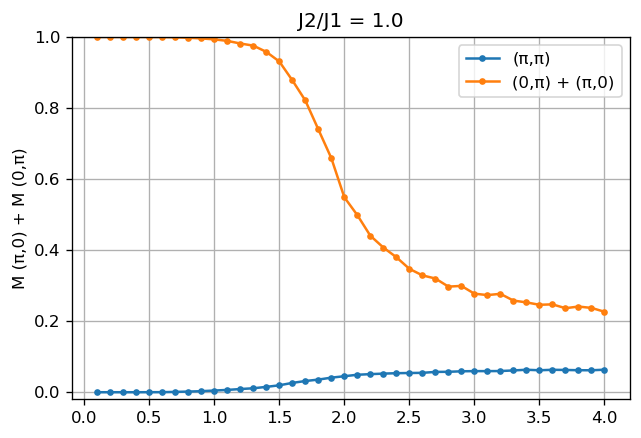

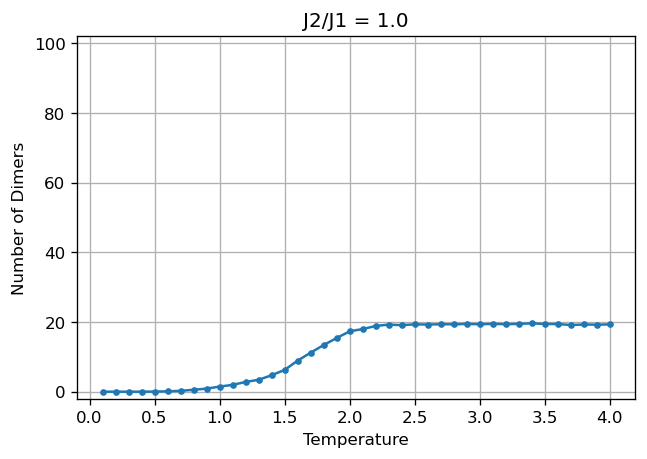

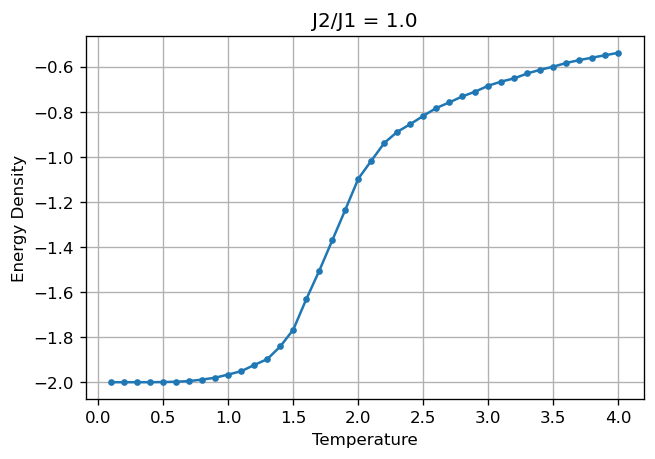

In [80]:
plt.figure(dpi=120)
plt.plot(T_list, staggered_magnetization_ππ, '.-' )
plt.plot(T_list, staggered_magnetization_0π + staggered_magnetization_π0, '.-' )
plt.grid(True)
plt.xlabel("Temperature")
plt.ylabel("M (π,0) + M (0,π)")
plt.title("J2/J1 = " + str(J2byJ1_list[k]))
plt.legend(["(π,π)", "(0,π) + (π,0)"])
plt.ylim([-0.02,1])
plt.show()

plt.figure(dpi=120)
plt.plot(T_list, no_of_dimers, '.-' )
plt.xlabel("Temperature")
plt.ylabel("Number of Dimers")
plt.title("J2/J1 = " + str(J2byJ1_list[k]))
plt.grid(True)
plt.ylim([-2,102])
plt.show()

plt.figure(dpi=120)
plt.plot(T_list, energy_val, '.-' )
plt.xlabel("Temperature")
plt.ylabel("Energy Density")
plt.title("J2/J1 = " + str(J2byJ1_list[k]))
plt.grid(True)
plt.show()

In [25]:
import csv
J2byJ1_list = np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1])
T_list = np.arange(4.0, 0.0 , -0.1)

energy_matrix = []
staggered_magnetization_ππ_matrix = []
staggered_magnetization_0π_matrix = []
staggered_magnetization_π0_matrix = []
no_of_dimers_matrix = []

for J2byJ1 in J2byJ1_list: 
    rows = []
    with open("anneal_data/Ising_" + str(J2byJ1) + "_L_" + str(n) + "_AFM_initial_" + "down" + ".csv", 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            rows.append([float(i) for i in row])

    energy_val = np.array(rows).T[2]
    total_mag = np.array(rows).T[4]
    staggered_magnetization_ππ = np.array(rows).T[6]
    staggered_magnetization_err_ππ = np.array(rows).T[7]
    staggered_magnetization_0π = np.array(rows).T[8]
    staggered_magnetization_err_0π = np.array(rows).T[9]
    staggered_magnetization_π0 = np.array(rows).T[10]
    staggered_magnetization_err_π0 = np.array(rows).T[11]

    no_of_dimers = np.array(rows).T[12]
    
    energy_matrix.append(energy_val)
    staggered_magnetization_ππ_matrix.append(staggered_magnetization_ππ)
    staggered_magnetization_0π_matrix.append(staggered_magnetization_0π)
    staggered_magnetization_π0_matrix.append(staggered_magnetization_π0)
    no_of_dimers_matrix.append(no_of_dimers)

M = len(T_list)
N = len(J2byJ1_list)

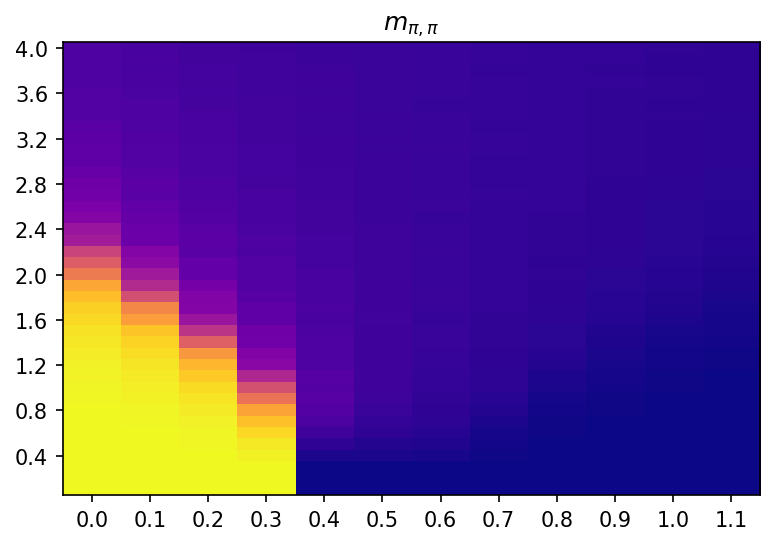

In [26]:
plt.figure(dpi=150)
plt.imshow(np.array(staggered_magnetization_ππ_matrix).T, cmap = 'plasma' , interpolation = 'nearest', aspect = 'auto')
# plt.imshow(staggered_magnetization , cmap = 'plasma' , interpolation = 'nearest', vmin = 0, vmax = 1)

ax = plt.gca();

# # Major ticks
ax.set_xticks(np.arange(0, N, 1))
ax.set_yticks(np.arange(0, M, 4))

# # Labels for major ticks
ax.set_xticklabels(J2byJ1_list.round(1))
ax.set_yticklabels(T_list.round(2)[::4])
# ax.invert_yaxis()
# ax.invert_xaxis()
plt.title(r'$m_{\pi, \pi}$')
# plt.colorbar()

plt.show()

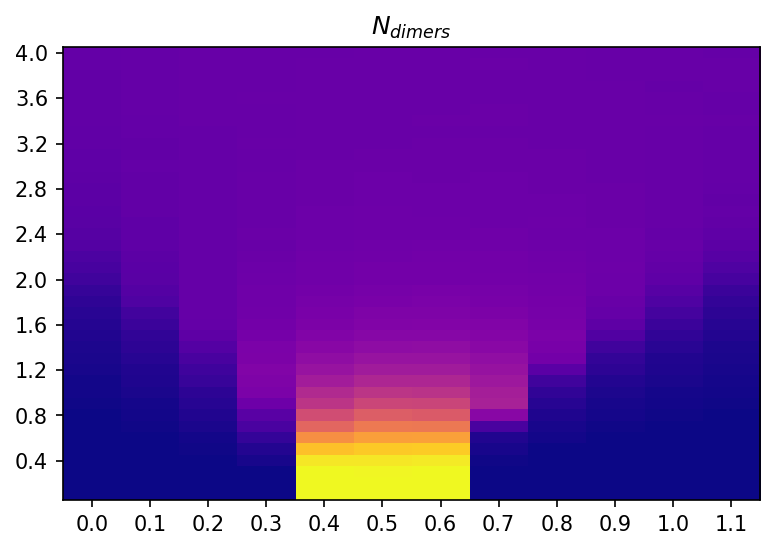

In [27]:
plt.figure(dpi=150)
plt.imshow(np.array(no_of_dimers_matrix).T, cmap = 'plasma' , interpolation = 'nearest' , aspect = 'auto')
# plt.imshow(staggered_magnetization , cmap = 'plasma' , interpolation = 'nearest', vmin = 0, vmax = 1)

ax = plt.gca();

# # Major ticks
ax.set_xticks(np.arange(0, N, 1))
ax.set_yticks(np.arange(0, M, 4))

# # Labels for major ticks
ax.set_xticklabels(J2byJ1_list.round(1))
ax.set_yticklabels(T_list.round(2)[::4])
# ax.invert_yaxis()
# ax.invert_xaxis()
plt.title(r'$N_{dimers}$')
# plt.colorbar()

plt.show()

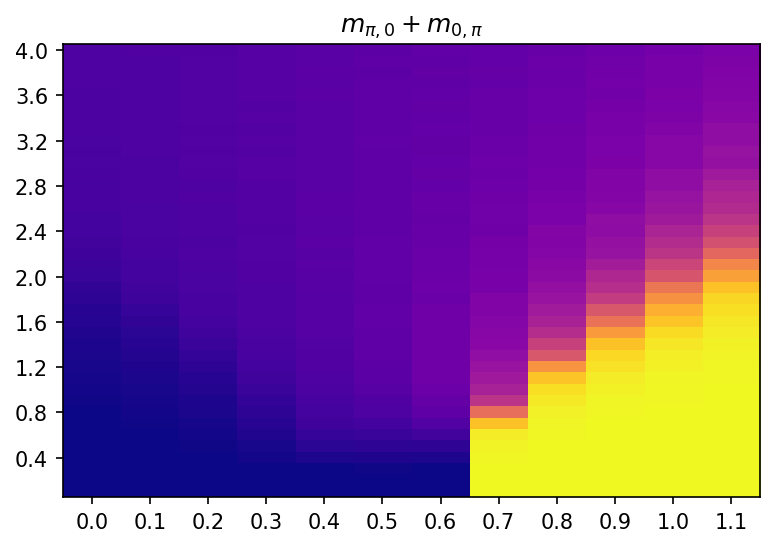

In [28]:
plt.figure(dpi=150)
plt.imshow(np.array(staggered_magnetization_0π_matrix).T + np.array(staggered_magnetization_π0_matrix).T, cmap = 'plasma' , interpolation = 'nearest', aspect = 'auto')
# plt.imshow(staggered_magnetization , cmap = 'plasma' , interpolation = 'nearest', vmin = 0, vmax = 1)

ax = plt.gca();

# # Major ticks
ax.set_xticks(np.arange(0, N, 1))
ax.set_yticks(np.arange(0, M, 4))

# # Labels for major ticks
ax.set_xticklabels(J2byJ1_list.round(1))
ax.set_yticklabels(T_list.round(2)[::4])
# ax.invert_yaxis()
# ax.invert_xaxis()
plt.title(r'$m_{\pi, 0} + m_{0, \pi}$')
# plt.colorbar()

plt.show()